In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [2]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [3]:
def potential(x,k,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x+x
    return poten

In [4]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [5]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

La=0
Lb =50
L=Lb-La  # domain length
N = 1000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=6
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

In [6]:
real_en_list=[]
for l in range(l_max):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid,b_lap,scale)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num].detach()
    real_en_list.append(real_en)

In [7]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    
    loss=0
    for l in range(l_max):
        centrifugal_poten=-b_lap*(l+1)*l/grid**2
        V_diag=model(grid)+centrifugal_poten
        A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
        eigenvalues= torch.linalg.eigvalsh(A)
        output=eigenvalues[:en_num]
        
        loss+=loss_fn(output,real_en_list[l])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:64.64775848388672,time:0.2072441577911377,lr:0.01
epoch:10,loss:8.348247528076172,time:0.8644876480102539,lr:0.01
epoch:20,loss:5.7889533042907715,time:1.4969239234924316,lr:0.01
epoch:30,loss:13.017739295959473,time:2.1350951194763184,lr:0.01
epoch:40,loss:8.862031936645508,time:2.7848901748657227,lr:0.01
epoch:50,loss:5.517638683319092,time:3.410504102706909,lr:0.01
epoch:60,loss:2.6180148124694824,time:4.05120849609375,lr:0.01
epoch:70,loss:8.725522994995117,time:4.691524267196655,lr:0.01
epoch:80,loss:5.77020263671875,time:5.32154393196106,lr:0.01
epoch:90,loss:2.9023759365081787,time:5.959078311920166,lr:0.01
epoch:100,loss:7.104861736297607,time:6.589723110198975,lr:0.01
epoch:110,loss:7.707178115844727,time:7.219098329544067,lr:0.01
epoch:120,loss:10.963377952575684,time:7.852029323577881,lr:0.01
epoch:130,loss:3.0946013927459717,time:8.48250126838684,lr:0.01
epoch:140,loss:2.3982813358306885,time:9.107132196426392,lr:0.01
epoch:150,loss:2.4236226081848145,time:9.73

In [8]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

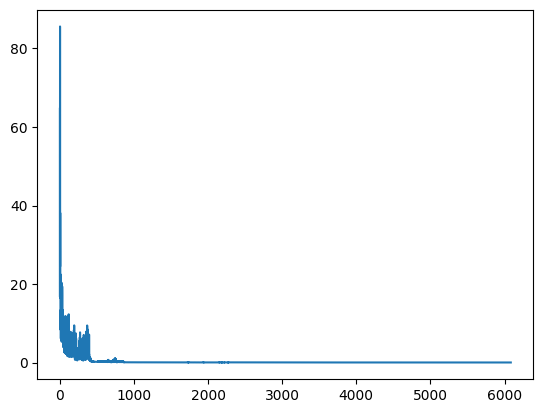

In [9]:
plt.plot(loss_list)
plt.show()

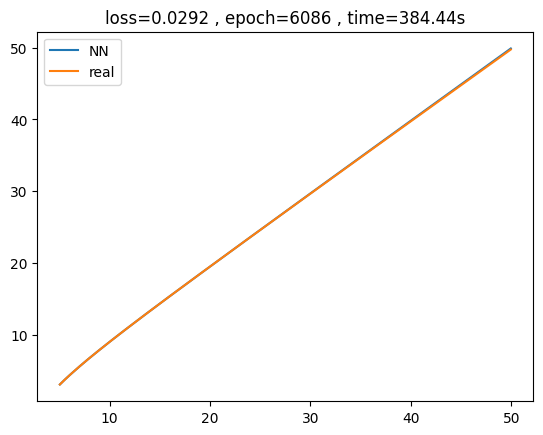

In [10]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


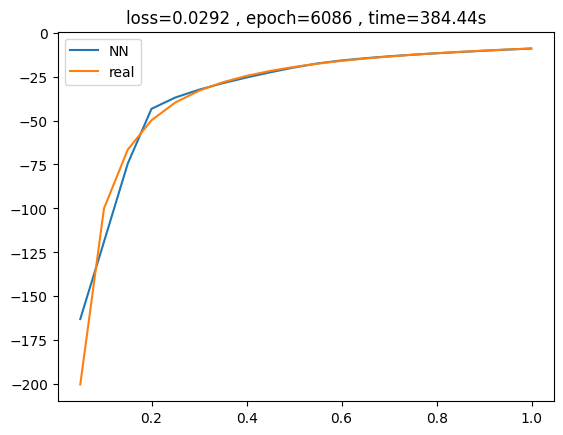

In [11]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:20]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [12]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

real_en=real_en_list[0]
error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([-2.6703e-05,  5.2946e-02,  3.8334e-02,  2.9287e-02,  1.7414e-02,
         9.6018e-03,  1.9037e-02,  1.7515e-02,  1.6627e-02,  1.7817e-02,
         1.8092e-02,  1.9094e-02,  1.9527e-02,  1.9120e-02,  1.8677e-02,
         1.8384e-02,  1.8400e-02,  1.8542e-02,  1.8728e-02,  1.8964e-02,
         1.9073e-02,  1.9029e-02,  1.8898e-02,  1.8724e-02,  1.8518e-02,
         1.8282e-02,  1.8017e-02,  1.7780e-02,  1.7593e-02,  1.7494e-02],
       device='cuda:6', grad_fn=<SubBackward0>)
relative error: tensor([ 5.6740e-07, -4.5210e-03, -9.0836e-03, -3.0691e-02,  1.5967e-02,
         3.6499e-03,  4.8730e-03,  3.4883e-03,  2.7591e-03,  2.5629e-03,
         2.3147e-03,  2.2120e-03,  2.0755e-03,  1.8835e-03,  1.7189e-03,
         1.5909e-03,  1.5053e-03,  1.4405e-03,  1.3869e-03,  1.3431e-03,
         1.2956e-03,  1.2429e-03,  1.1896e-03,  1.1381e-03,  1.0889e-03,
         1.0415e-03,  9.9598e-04,  9.5501e-04,  9.1927e-04,  8.9022e-04],
       device='cuda:6', grad_fn=<DivBackward0

energy level while l=0


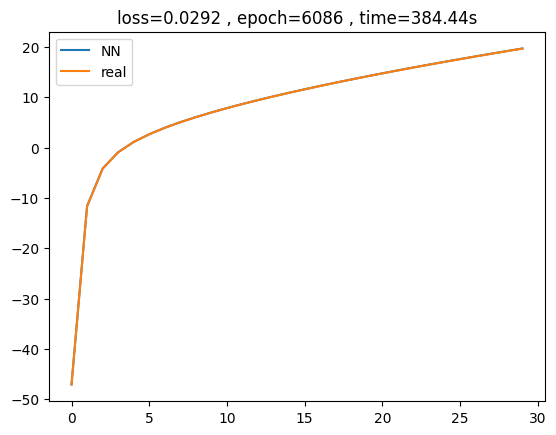

In [13]:
print('energy level while l=0')
plt.plot(output[:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

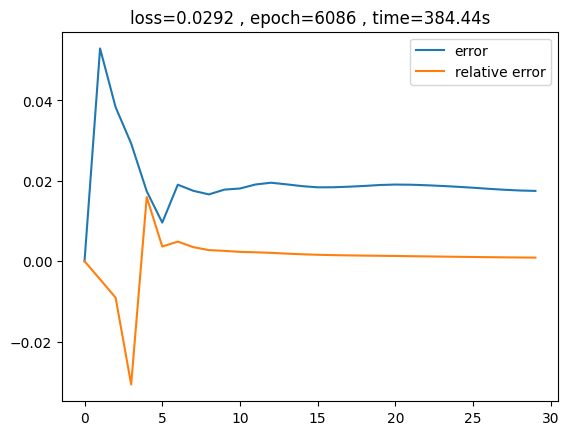

In [14]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()